# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.
### This is the main example notebook

Hans Buehler, June 30 2022


In [2]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker
Tensorflow version 2.7.1 running on 1 CPUs and 0 GPUs


2023-01-08 13:34:40.830639: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 13:34:40.830680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-44-231.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


Deep Hedging AI says hello  ... Tensorflow version 2.7.1 running on 1 CPUs and 0 GPUs


2023-01-08 10:56:45.878098: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 10:56:45.878148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-57-75.us-east-2.compute.internal): /proc/driver/nvidia/version does not exist


## Deep Hedging in a Black \& Scholes World

2023-01-08 10:56:46.503511: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 10:56:47.862506: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Caching enabled @ '/home/ec2-user/dh_cache/525a190095ec9decf339c9045024ab3d.pck'
Cache successfully loaded. Current epoch: 399
Nothing to do: cached model loaded from /home/ec2-user/dh_cache/525a190095ec9decf339c9045024ab3d.pck represents a trained model up to 400 epochs (you have asked to train for 400 epochs).
Raise number of epochs or turn off caching to re-start training.

Plotting results for the trained model.

                                                                                                                                                                                                         


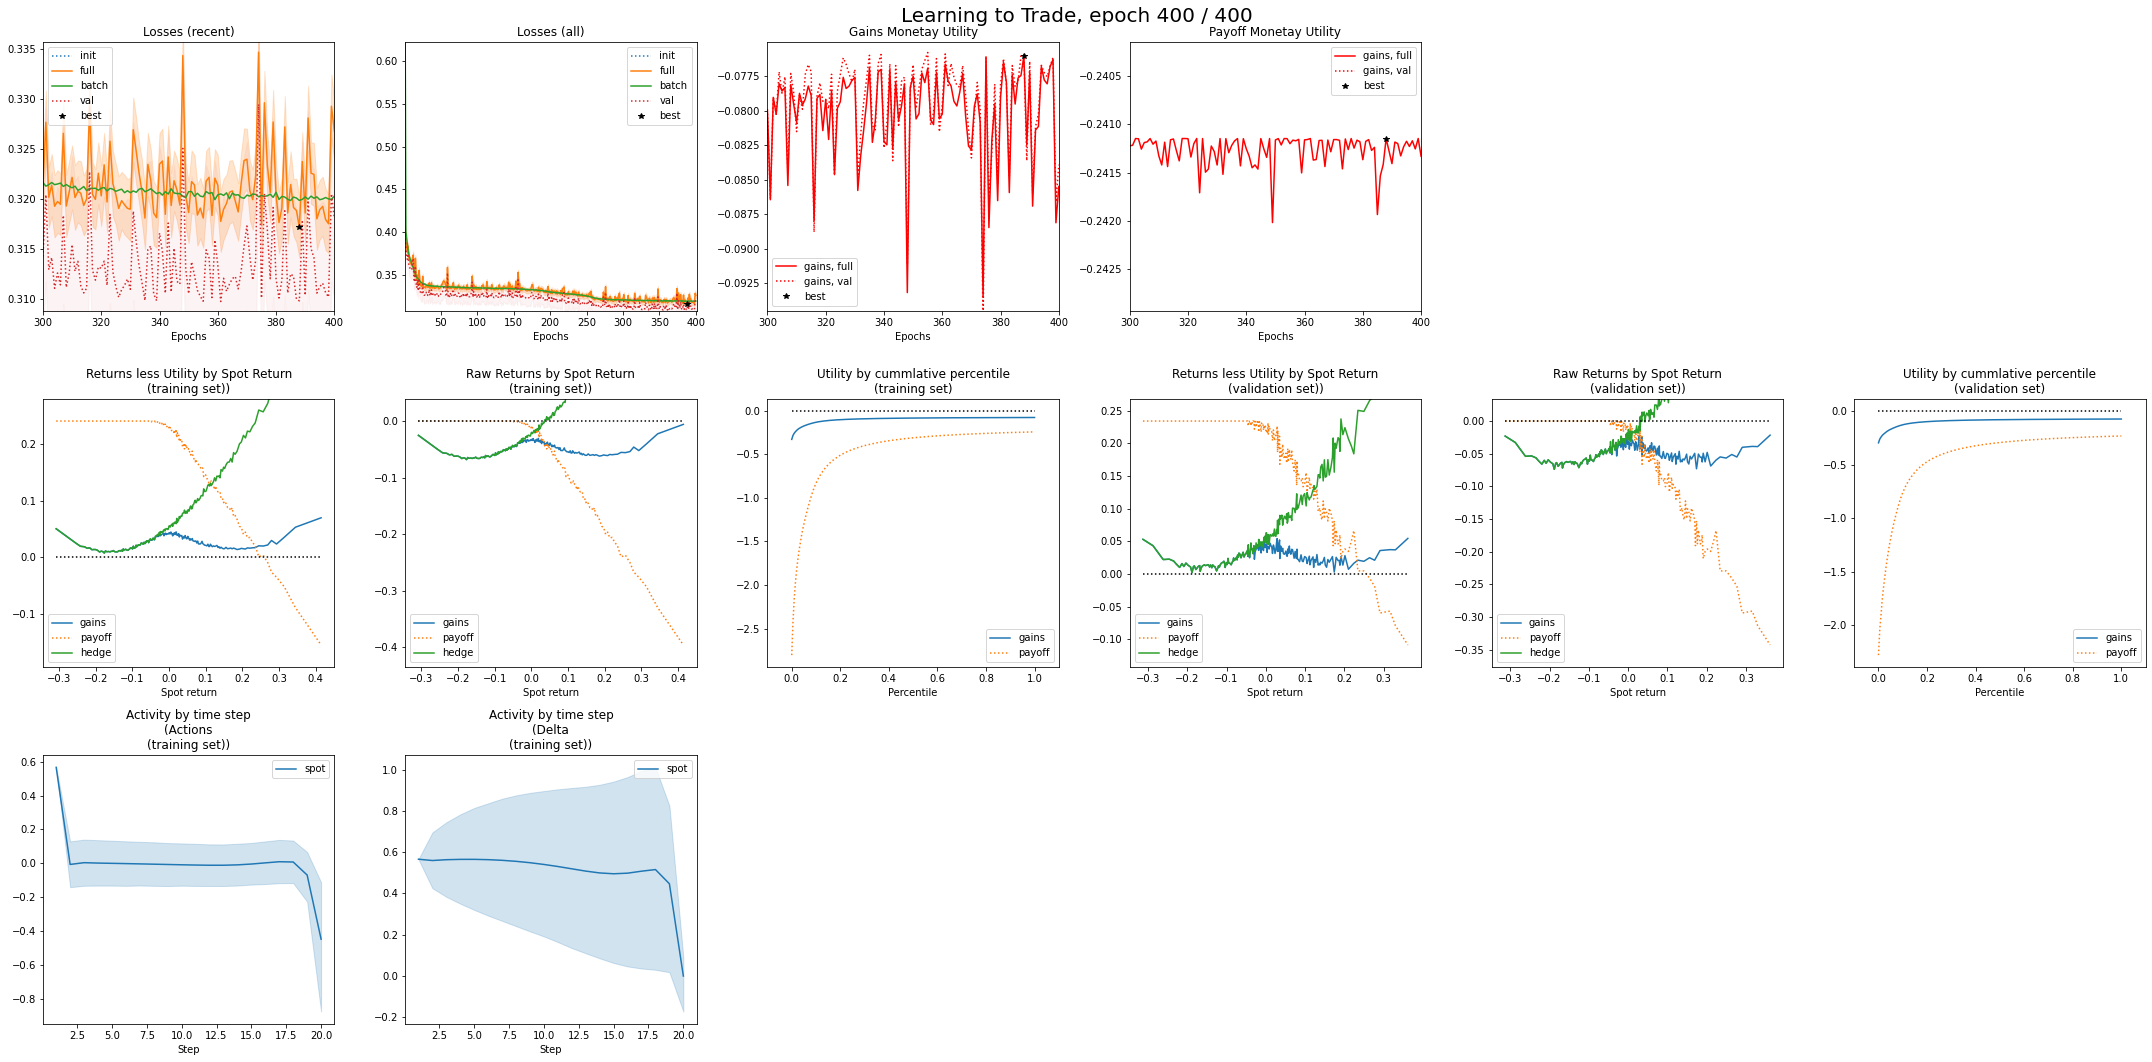

Training 400/400 epochs; 943 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 4.85658 (0.0736884), full 0.326823 (0.00299657), best 0.317169 (0.0736884), batch 0.320299, val 0.318093 (0.00823519). Best epoch 387. Last cached epoch 399. | time elapsed 3s; time per epoch 0s; estimated time remaining 0s                         
 Status: Ran all 400 epochs.
 Weights set to best epoch: 387

Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gym.agent.network['final_activation'] = linear # Network activation function for the last layer; default: linear
config.gym.agent.network['width'] = 20 # Network width; default: 20
config.gym.agent.network['zero_model'] = False # Create a model with z

In [2]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

### Comparison to Black & Scholes
#### See also notebooks/blackscholes

Note that we use medium risk aversion, hence the hedge is not expected to match the risk-neutral hedge. See the sub directory <tt>blackscholes</tt> for experiments approximating the black & scholes solution

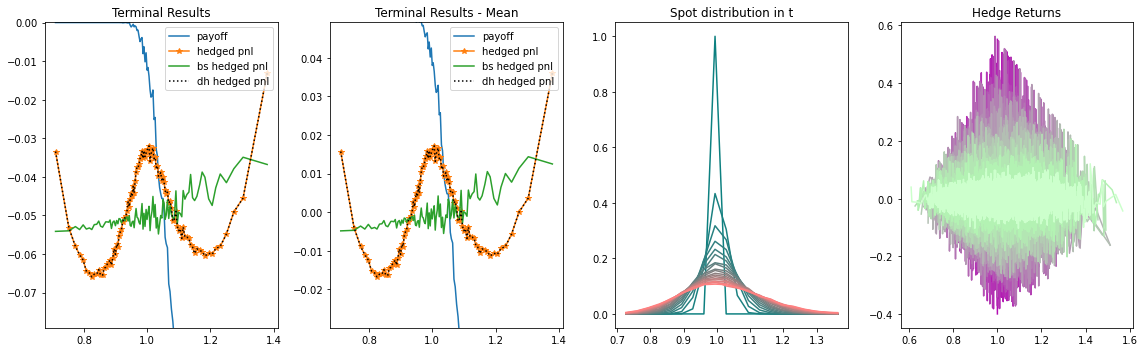

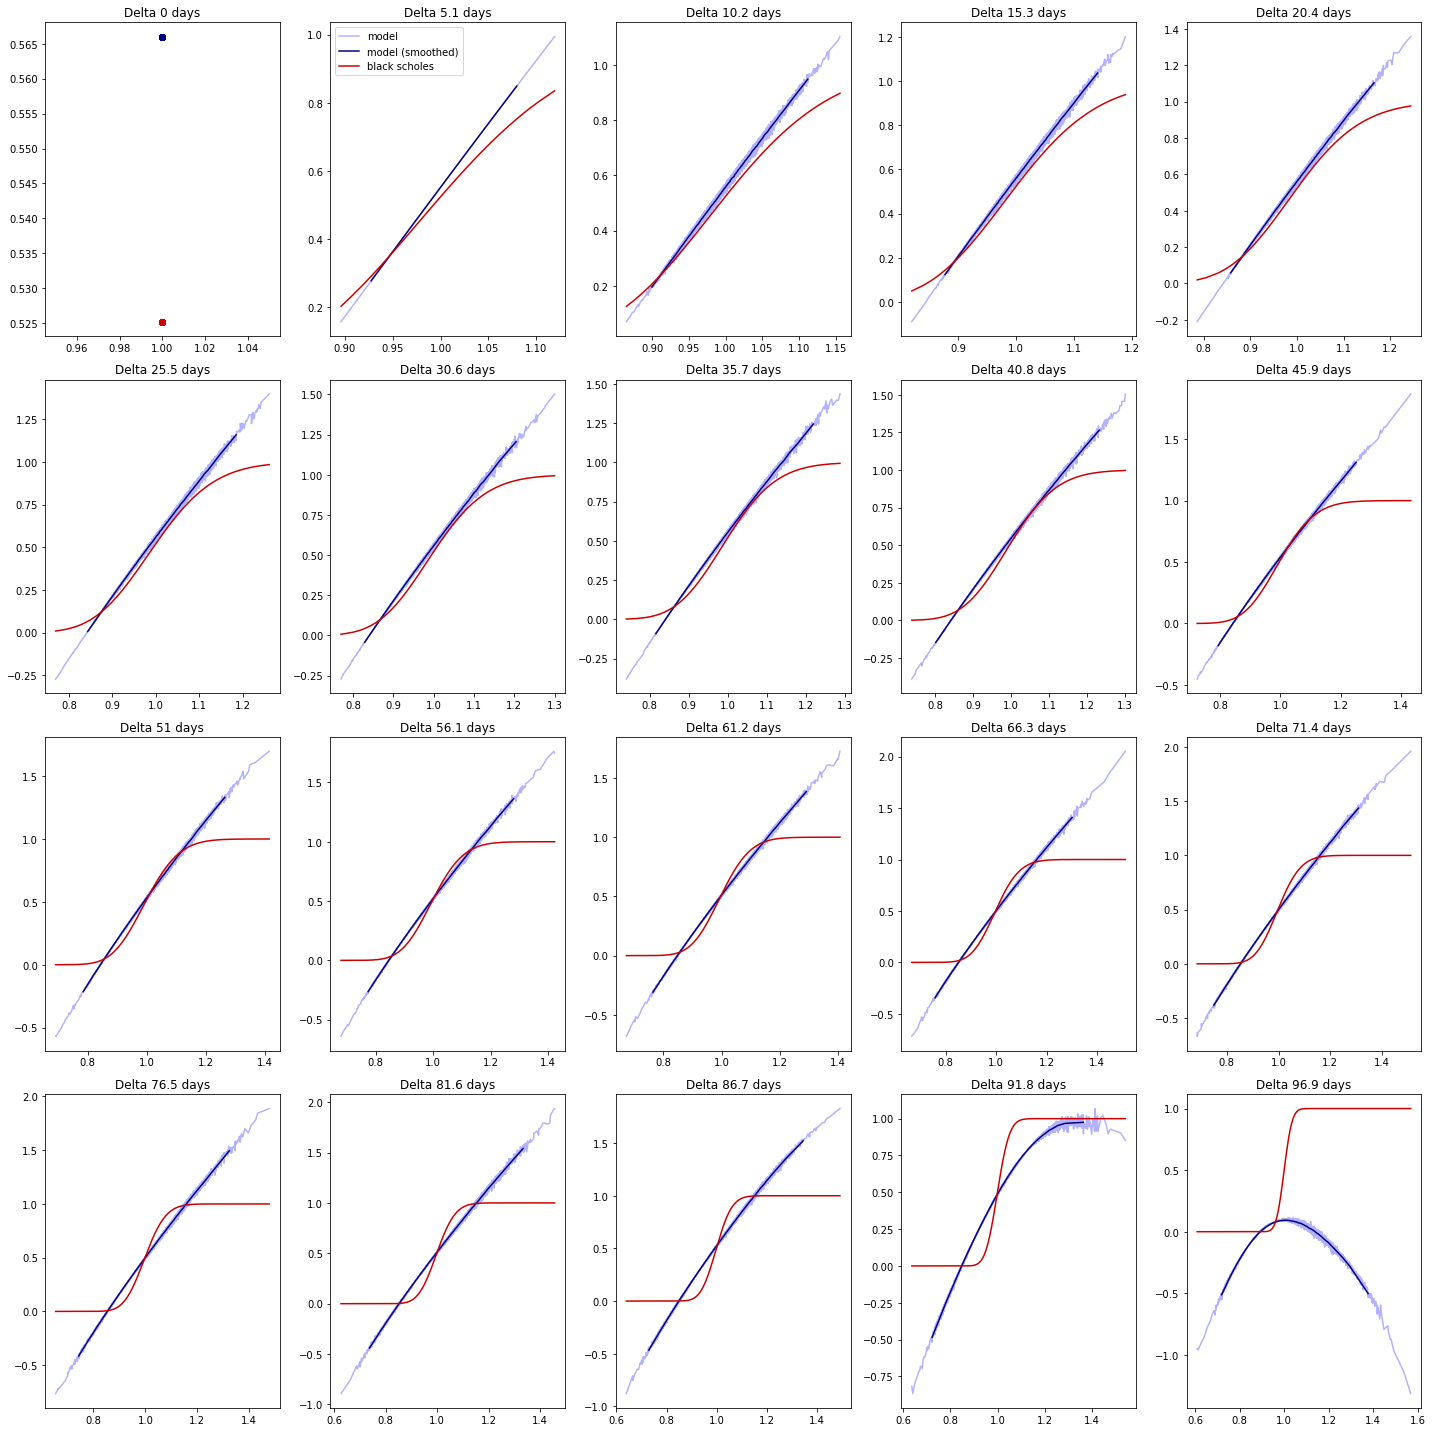

In [3]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

plot_bs_hedge.plot_blackscholes( world, gym, config )

Deep Hedging AI says hello  ... 

## Deep Hedging in simple Stochastic Volatility World

Caching enabled @ '/home/ec2-user/dh_cache/19f324ebc0546708f72330f69145add2.pck'
Cache successfully loaded. Current epoch: 599
Nothing to do: cached model loaded from /home/ec2-user/dh_cache/19f324ebc0546708f72330f69145add2.pck represents a trained model up to 600 epochs (you have asked to train for 600 epochs).
Raise number of epochs or turn off caching to re-start training.

Plotting results for the trained model.

                                                                                                                                                                                                         


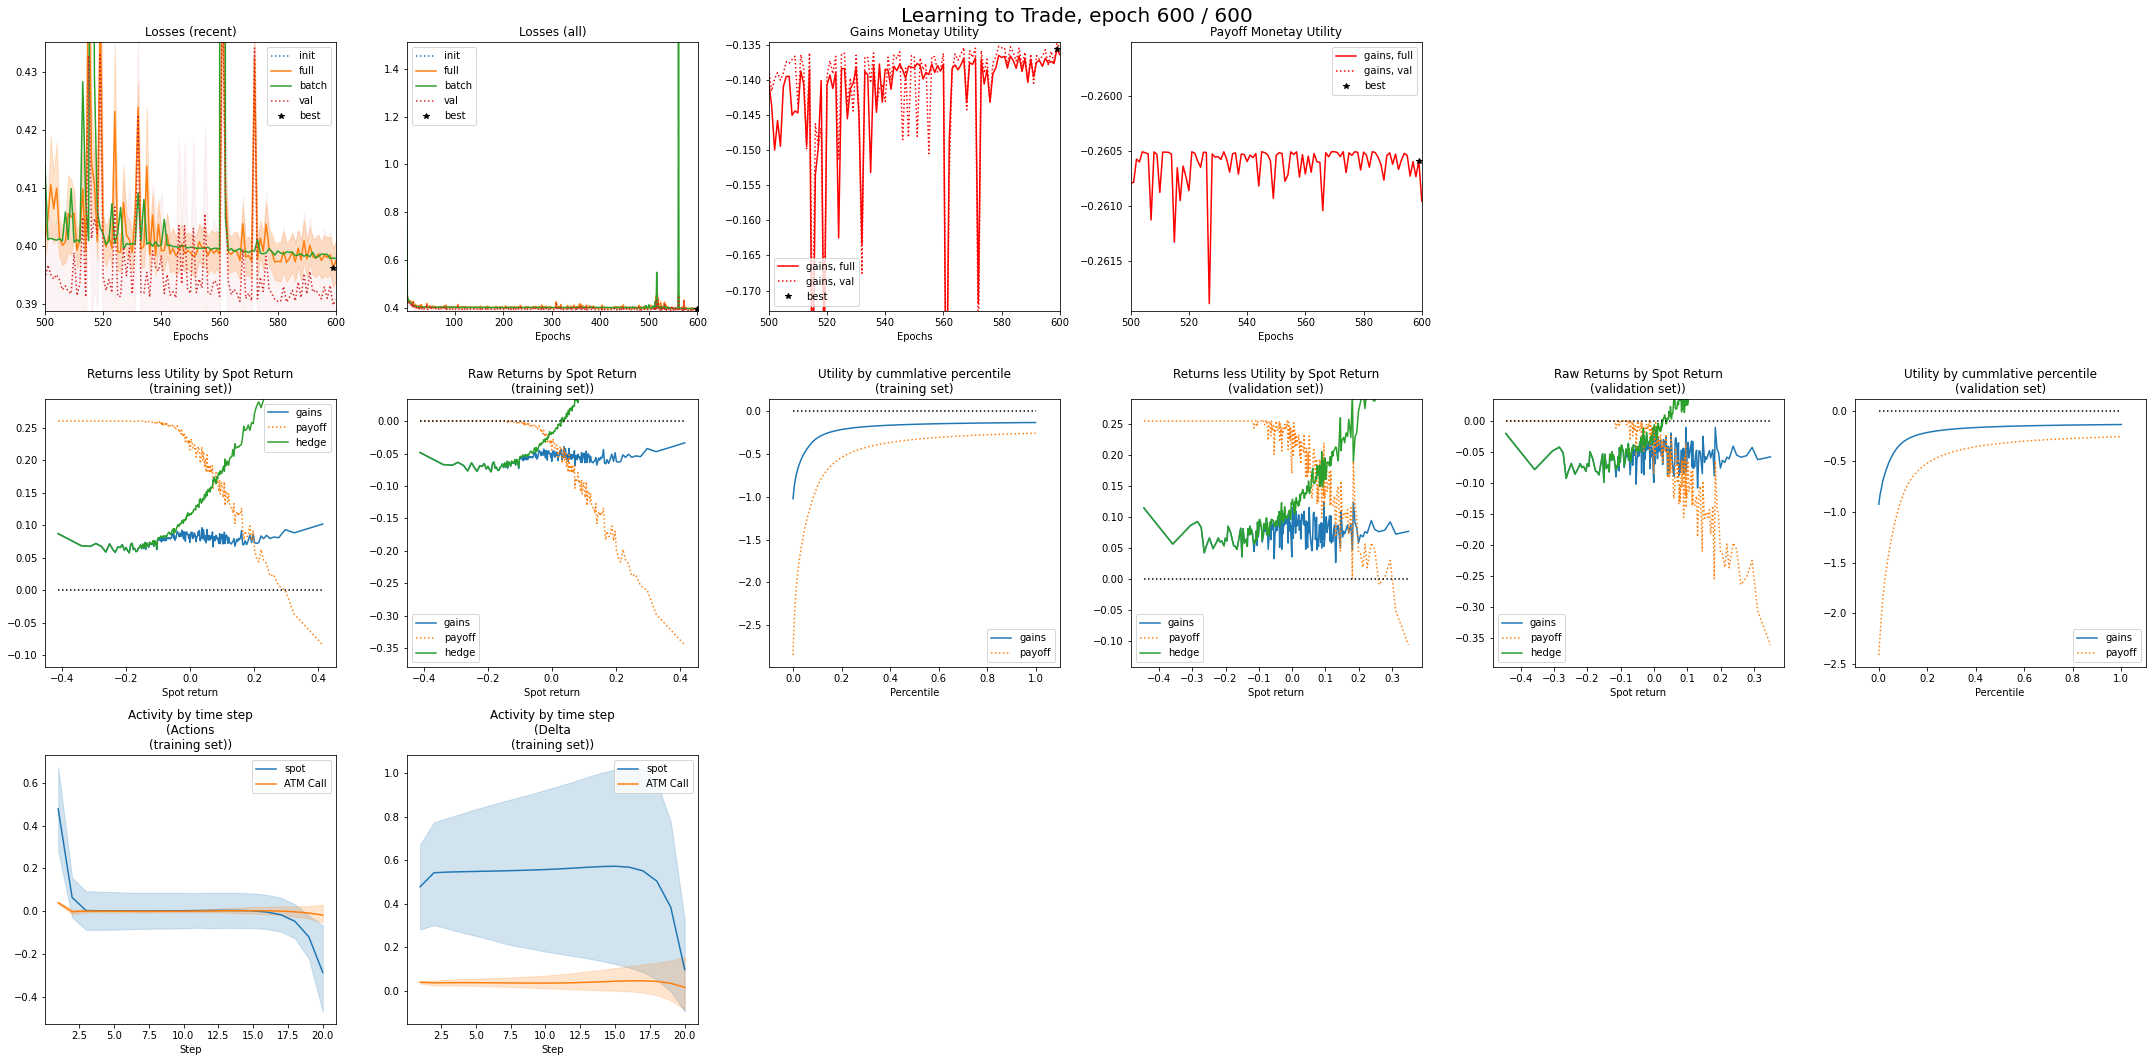

Training 600/600 epochs; 1004 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 5.58272 (0.0789162), full 0.397378 (0.00344696), best 0.396235 (0.0789162), batch 0.397774, val 0.390687 (0.0100645). Best epoch 598. Last cached epoch 599. | time elapsed 3s; time per epoch 0s; estimated time remaining 0s                         
 Status: Ran all 600 epochs.
 Weights set to best epoch: 598

Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gym.agent.network['final_activation'] = linear # Network activation function for the last layer; default: linear
config.gym.agent.network['width'] = 20 # Network width; default: 20
config.gym.agent.network['zero_model'] = False # Create a model with z

In [4]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.epochs = 600
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()